In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from mne_bids import BIDSPath
from nilearn.plotting import plot_markers
from nilearn import datasets

from utils import get_sub_coords, get_coord_atlas_labels

plt.style.use("figures.mplstyle")

In [9]:
result_path = BIDSPath(
    root="../results", datatype="erp", extension=".h5", check=False
)
result_files = result_path.match()
len(result_files)

9

In [10]:
sub_evoked = []
for result_path in result_files:
    with h5py.File(result_path, "r") as f:
        evoked = f['evoked'][...]
        lags = f['lags'][...]

        sub_evoked.append(evoked)

all_xcorrs = np.vstack(sub_evoked)
print(all_xcorrs.shape)

(1159, 2049)


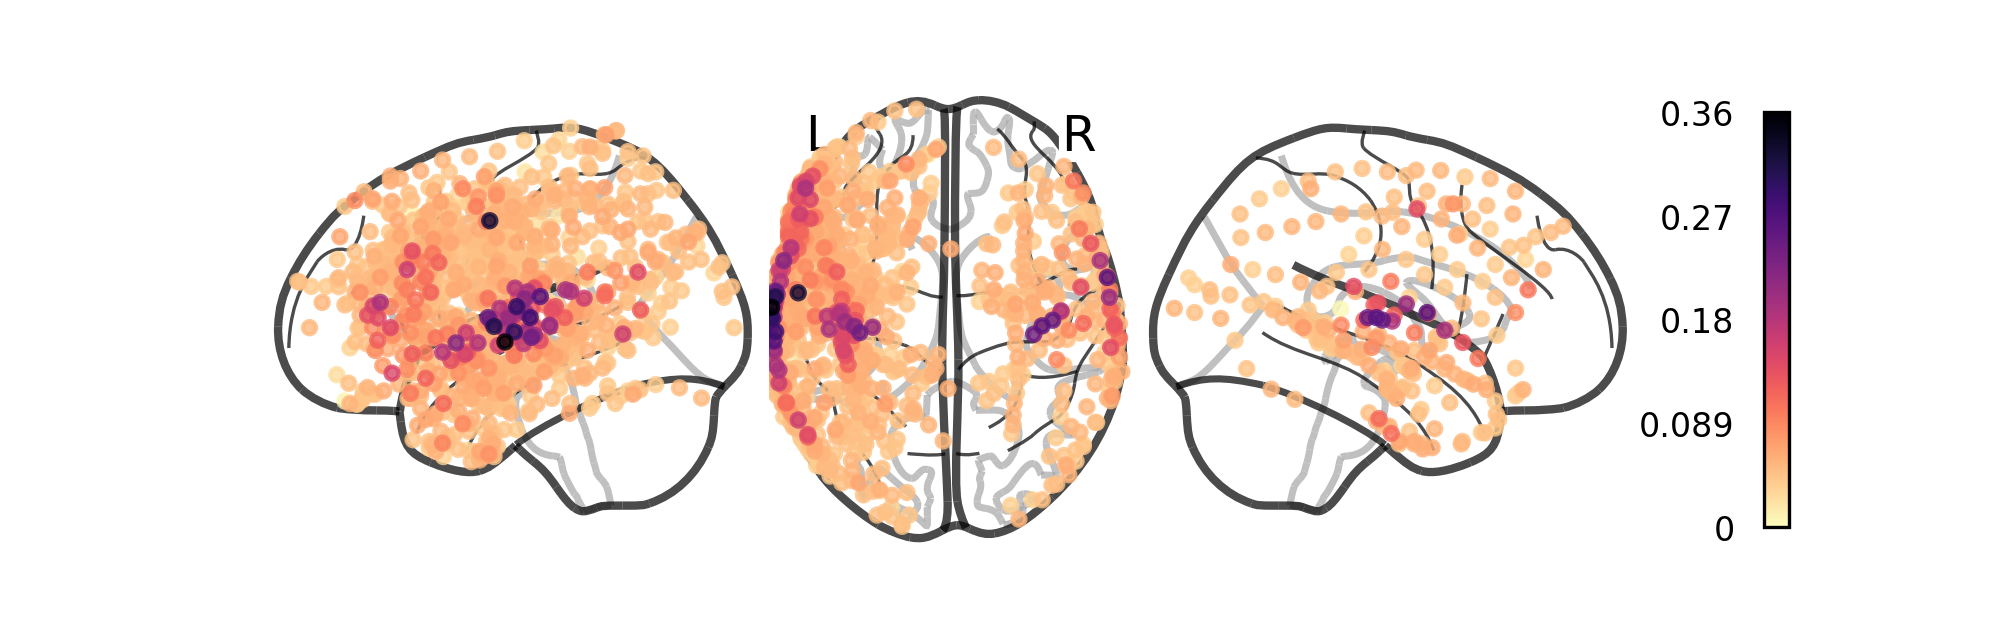

In [11]:
coords = get_sub_coords()
values = all_xcorrs.max(-1)
order = values.argsort()

fig, ax = plt.subplots(figsize=(2.2*3, 2), layout='constrained', dpi=300)
plot_markers(values[order], coords[order],
                node_size=10, display_mode='lzr',
                node_cmap='magma_r', colorbar=True,
                alpha=0.8, node_vmin=0,
                figure=fig, axes=ax)
fig.savefig("../figures/figure2/erp-brainmap.svg")
fig.show()

In [12]:
atlas = datasets.fetch_atlas_destrieux_2009()
indices = atlas['labels'].index
names = atlas['labels'].name
atlas_labels = {idx: name for idx, name in zip(indices, names)}

original_elec_labels = get_coord_atlas_labels(coords, atlas['maps'], atlas_labels)
elec_labels = [label.split()[1].split("_", 1)[1] for label in original_elec_labels]  # for destrieux
roi_mask = np.isin(elec_labels, ['temp_sup-Lateral'])

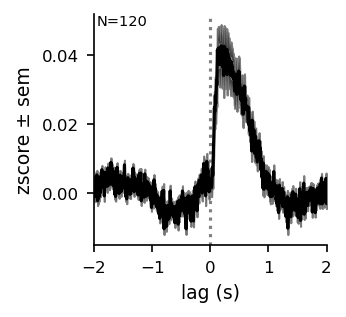

In [13]:
mean = all_xcorrs[roi_mask].mean(0)
err = all_xcorrs[roi_mask].std(0) / np.sqrt(all_xcorrs[roi_mask].shape[0])

xaxis = lags / 512

fig, ax = plt.subplots(figsize=(2, 2))
ax.axvline(0, c='gray', ls=':')
ax.fill_between(xaxis, mean - err, mean + err, alpha=0.5, color='k')
ax.plot(xaxis, mean, color='k')
ax.set_xlabel("lag (s)")
ax.set_ylabel("zscore ± sem")

ax.text(x=0.01, y=1,
        s=f"N={len(all_xcorrs[roi_mask])}", fontsize=7,
        transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left')

ax.set_xlim(-2, 2)

fig.savefig('../figures/figure2/erp-timecourse.svg')
fig.show()